### Imports

In [10]:
import networkx as nx
import networkx.algorithms.isomorphism as iso
import pickle
from functools import reduce

### Graphs initialization

In [11]:
# main (code) graph
ctrl = pickle.load(open('../Data/ctrl_graph.p','rb'))
planning = pickle.load(open('../Data/planning_graph.p','rb'))

### 1. Change this
# ↓↓↓   ↓↓↓

In [12]:
pattern_name='Adapter'
pattern = nx.DiGraph()
pattern.add_edge('Adapter','ClientInterface',type='Generalization')
pattern.add_edge('Adapter','Services',type='Association')

### Graphs visualizations [Optional]

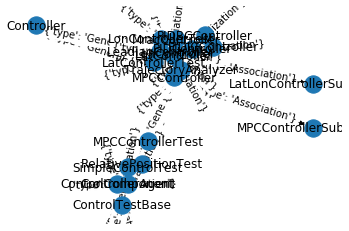

In [13]:
# ctrl graph
pos=nx.spring_layout(ctrl)
nx.draw_networkx_edge_labels(ctrl,pos)
nx.draw(ctrl,pos,with_labels=True)

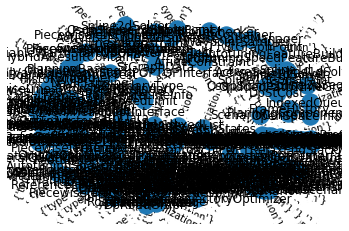

In [14]:
# planning graph
pos=nx.spring_layout(planning)
nx.draw_networkx_edge_labels(planning,pos)
nx.draw(planning,pos,with_labels=True)

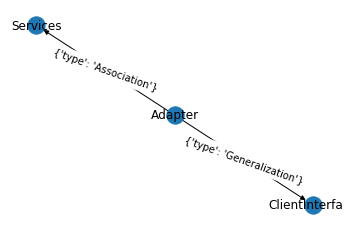

In [15]:
# pattern graph
pos=nx.spring_layout(pattern)
nx.draw_networkx_edge_labels(pattern,pos)
nx.draw(pattern,pos,with_labels=True)

### Finding matched patterns

In [16]:
# in ctrl graph
import networkx.algorithms.isomorphism as iso
nm = iso.categorical_edge_match('type', 'xyz')
ctrl_DiGM = iso.DiGraphMatcher(ctrl,pattern,edge_match=nm)
#ctrl_DiGM.subgraph_is_isomorphic()
ctrl_subgraphs = [graph for graph in ctrl_DiGM.subgraph_isomorphisms_iter()]
print (ctrl_subgraphs)

[{'LatController': 'Adapter', 'Controller': 'ClientInterface', 'LatLonControllerSubmodule': 'Services'}, {'LonController': 'Adapter', 'Controller': 'ClientInterface', 'LatLonControllerSubmodule': 'Services'}, {'MPCController': 'Adapter', 'Controller': 'ClientInterface', 'MPCControllerSubmodule': 'Services'}]


In [17]:
# in planning graph
import networkx.algorithms.isomorphism as iso
nm = iso.categorical_edge_match('type', 'xyz')
planning_DiGM = iso.DiGraphMatcher(planning,pattern,edge_match=nm)
#planning_DiGM.subgraph_is_isomorphic()
planning_subgraphs = [graph for graph in planning_DiGM.subgraph_isomorphisms_iter()]
print (planning_subgraphs)

[{'PiecewiseJerkTrajectory1d': 'Adapter', 'Curve1d': 'ClientInterface', 'PiecewiseJerkSpeedNonlinearOptimizer': 'Services'}, {'PiecewiseJerkTrajectory1d': 'Adapter', 'Curve1d': 'ClientInterface', 'PiecewiseJerkSpeedNonlinearIpoptInterface': 'Services'}]


### Merge patterns

In [18]:
# function definitions
def get_key(val,l): 
    for key, value in l.items(): 
         if val == value: 
             return key 
  
    return "key doesn't exist"

def mergeList(subList,pat):
    result=[]
    while(len(subList)>0):
        res1 = []
        res1.append(subList[0])
        for j in range(1,len(subList)):
            flag = True
            for k in pat:
                if(get_key(k,subList[0])!=get_key(k,subList[j])):
                    flag = False
            if(flag==True):
                res1.append(subList[j])
        result.append(res1)
        l3 = [x for x in subList if x not in res1]
        subList = l3
    return result

def merge(disconnected_patterns,fixed):
    lst = mergeList(disconnected_patterns,fixed)
    return list(map(lambda item: dict(item[0],**item[1]) if len(item)>1 else item[0],lst))

### 2. Change this
# ↓↓↓   ↓↓↓

In [19]:
fixed_parts ={'Adapter','Services','ClientInterface'}

In [20]:
final_planning_subgraphs=merge(planning_subgraphs,fixed_parts)
final_ctrl_subgraphs=merge(ctrl_subgraphs,fixed_parts)
print('planning :\n',*final_planning_subgraphs,sep='\n')
print('\n')
print('Control :\n',*final_ctrl_subgraphs,sep='\n')

planning :

{'PiecewiseJerkTrajectory1d': 'Adapter', 'Curve1d': 'ClientInterface', 'PiecewiseJerkSpeedNonlinearOptimizer': 'Services'}
{'PiecewiseJerkTrajectory1d': 'Adapter', 'Curve1d': 'ClientInterface', 'PiecewiseJerkSpeedNonlinearIpoptInterface': 'Services'}


Control :

{'LatController': 'Adapter', 'Controller': 'ClientInterface', 'LatLonControllerSubmodule': 'Services'}
{'LonController': 'Adapter', 'Controller': 'ClientInterface', 'LatLonControllerSubmodule': 'Services'}
{'MPCController': 'Adapter', 'Controller': 'ClientInterface', 'MPCControllerSubmodule': 'Services'}


### Pruning

In [21]:
variable_parts = set(pattern.nodes())-fixed_parts
pruned_planning_subgraphs=list(filter(lambda pattern: len(pattern)>=len(fixed_parts)+2*len(variable_parts),final_planning_subgraphs))
pruned_ctrl_subgraphs=list(filter(lambda pattern: len(pattern)>=len(fixed_parts)+2*len(variable_parts),final_ctrl_subgraphs))
print('planning :\n',*pruned_planning_subgraphs,sep='\n')
print('\n')
print('Control :\n',*pruned_ctrl_subgraphs,sep='\n')

planning :

{'PiecewiseJerkTrajectory1d': 'Adapter', 'Curve1d': 'ClientInterface', 'PiecewiseJerkSpeedNonlinearOptimizer': 'Services'}
{'PiecewiseJerkTrajectory1d': 'Adapter', 'Curve1d': 'ClientInterface', 'PiecewiseJerkSpeedNonlinearIpoptInterface': 'Services'}


Control :

{'LatController': 'Adapter', 'Controller': 'ClientInterface', 'LatLonControllerSubmodule': 'Services'}
{'LonController': 'Adapter', 'Controller': 'ClientInterface', 'LatLonControllerSubmodule': 'Services'}
{'MPCController': 'Adapter', 'Controller': 'ClientInterface', 'MPCControllerSubmodule': 'Services'}


### Storage

In [22]:
pickle.dump(pruned_planning_subgraphs,open('../Data/Found_patterns/'+pattern_name+'_planning.p','wb'))
pickle.dump(pruned_ctrl_subgraphs,open('../Data/Found_patterns/'+pattern_name+'_control.p','wb'))
pickle.dump(pattern,open('../Data/design_patterns/'+pattern_name+'.p','wb'))
pickle.dump(fixed_parts,open('../Data/design_patterns/'+pattern_name+'_fixed.p','wb'))